<a href="https://colab.research.google.com/github/prathyushalahari/AI-Bayesian-Network-Model/blob/main/BNN_U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tensorflow tensorflow-probability opencv-python


In [ ]:
'''STEP-2 : LOAD THE DATA'''
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
# Set the data paths
train_images_path = '/content/drive/MyDrive/REFUGE2/train/images'
train_masks_path = '/content/drive/MyDrive/REFUGE2/train/mask'

# Load images and masks
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.resize(img, (256, 256))  # Resize to 256x256
        if img is not None:
            images.append(img)
    return np.array(images)

train_images = load_images_from_folder(train_images_path)
train_masks = load_images_from_folder(train_masks_path)

# Normalize images and masks
train_images = train_images / 255.0
train_masks = train_masks / 255.0

# Ensure masks are single-channel
train_masks = np.expand_dims(np.mean(train_masks, axis=-1), axis=-1)

# Split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print(f'Training Images Shape: {X_train.shape}')
print(f'Training Masks Shape: {y_train.shape}')


Training Images Shape: (320, 256, 256, 3)
Training Masks Shape: (320, 256, 256, 1)


In [4]:
from tensorflow.keras import layers, models

def montecarlo_dropout_unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder (downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    d1 = layers.Dropout(0.3)(p1, training=True)  # Monte Carlo Dropout

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    d2 = layers.Dropout(0.3)(p2, training=True)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder (upsampling)
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.concatenate([u1, c2])
    d3 = layers.Dropout(0.3)(u1, training=True)

    u2 = layers.UpSampling2D((2, 2))(d3)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.concatenate([u2, c1])
    d4 = layers.Dropout(0.3)(u2, training=True)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model

# Build the model
mc_dpout_unet = montecarlo_dropout_unet()
mc_dpout_unet.summary()
mc_dpout_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])






Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        295,040 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 256)  │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 256)  │              0 │ dropout_2[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 64)   │        147,520 │ up_sampling2d_1[0][0]  │
├──────────────────────

 Total params: 1,588,097 (6.06 MB)

 Trainable params: 1,588,097 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = mc_dpout_unet .fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1591s 78s/step - accuracy: 0.8510 - loss: 0.3257 - val_accuracy: 0.9832 - val_loss: 0.0583
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1587s 77s/step - accuracy: 0.9828 - loss: 0.0608 - val_accuracy: 0.9832 - val_loss: 0.0476
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1483s 74s/step - accuracy: 0.9830 - loss: 0.0508 - val_accuracy: 0.9832 - val_loss: 0.0490
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1564s 77s/step - accuracy: 0.9831 - loss: 0.0477 - val_accuracy: 0.9832 - val_loss: 0.0454
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1580s 76s/step - accuracy: 0.9829 - loss: 0.0455 - val_accuracy: 0.9832 - val_loss: 0.0447
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1514s 76s/step - accuracy: 0.9829 - loss: 0.0477 - val_accuracy: 0.9832 - val_loss: 0.0456
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1481s 74s/step - accuracy: 0.9830 - loss: 0.0459 - val_accuracy: 0.9832 - val_loss: 0.0477
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1515s 74s/step - accuracy: 0.9829 - loss: 0.0449 - val_accu

In [6]:
mc_dpout_unet.save('montecarlo_dropout_unet_final.keras')


In [7]:
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model('montecarlo_dropout_unet_final.keras')


In [8]:
# Assuming you have test data (X_test, y_test)
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Model Accuracy: {accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 102s 30s/step - accuracy: 0.9831 - loss: 0.0424
Model Accuracy: 98.32%


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/content/montecarlo_dropout_unet_final.keras'
model = load_model(model_path, compile=False)  # Load the model without recompiling

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calculate the DICE score.
    :param y_true: Ground truth mask (binary).
    :param y_pred: Predicted mask (binary).
    :param smooth: Small constant to avoid division by zero.
    :return: DICE coefficient.
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Predict using the loaded model on the test set (X_test)
y_pred_probs = model.predict(X_test, batch_size=1)
# Predicted probabilities for test images

# Apply threshold to convert probabilities to binary masks
y_pred = (y_pred_probs > 0.5).astype(np.float32)

# Calculate DICE for each test image and mask pair
dice_scores = []
for i in range(len(X_test)):
    dice_score = dice_coefficient(y_test[i], y_pred[i])
    dice_scores.append(dice_score.numpy())

# Average DICE score across all test images
average_dice = np.mean(dice_scores)
print(f'Average DICE Score: {average_dice:.4f}')


80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step
Average DICE Score: 0.9947


3/3 ━━━━━━━━━━━━━━━━━━━━ 96s 28s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


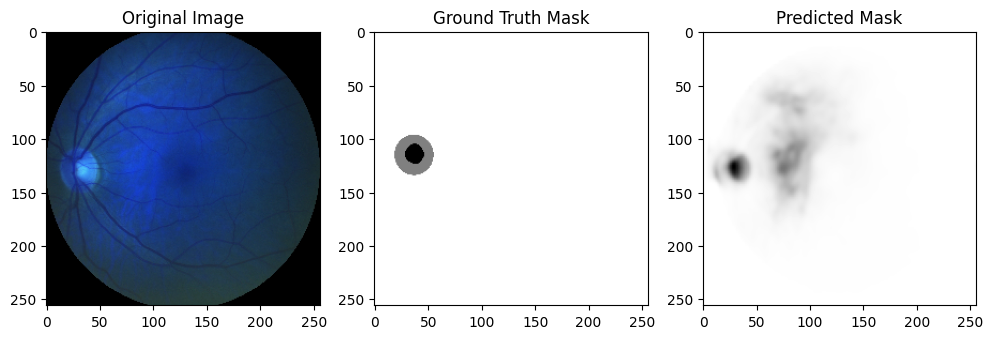

In [23]:
##Displaying Results

# from tensorflow.keras.models import load_model
# model_path = '/content/montecarlo_dropout_unet_final.keras'
# model = load_model(model_path, compile=False)

import matplotlib.pyplot as plt
def display_results(images, masks, predicted_masks, num_images=5):

# Predict on a single image from the validation set
  sample_image = X_test[0]
  predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))

# Plot original image, ground truth mask, and predicted mask
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 3, 1)
  plt.imshow(sample_image)
  plt.title('Original Image')

  plt.subplot(1, 3, 2)
  plt.imshow(y_test[0], cmap='gray')
  plt.title('Ground Truth Mask')

  plt.subplot(1, 3, 3)
  plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
  plt.title('Predicted Mask')

  plt.show()

# Predict on the test set
predicted_masks = model.predict(X_test)

# Display results for a few images from the test set
display_results(X_test, y_test, predicted_masks)
